#**CMLS HOMEWORK 1 : AUDIO EFFECT CLASSIFICATION**

#Libraries


In [ ]:
# Python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import librosa
import scipy as sp
import scipy.stats
import seaborn as sns
from sklearn import mixture
from sklearn.mixture import BayesianGaussianMixture



# Utility

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import Audio


# Scalers
from sklearn.preprocessing import MinMaxScaler

# Metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix 


# Classifiers

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import urllib.request
import tarfile




#Dataset import and process

In [ ]:
#downloading and extracting the dataset on colab's server
import urllib.request
urllib.request.urlretrieve ("https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz","a.tar.gz")
import tarfile
tar = tarfile.open("a.tar.gz")
tar.extractall()
tar.close()


In [ ]:

#forming a panda dataframe from the metadata file
data=pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

data["fold"].value_counts()


path="UrbanSound8K/audio/fold"

folds_list  = []
audios_list  = []
labels_list = []

#extracting the information and storing them in the corresponding lists

for i in tqdm(range(len(data))):
    fold_no=str(data.iloc[i]["fold"])
    folds_list.append(fold_no)
    file=data.iloc[i]["slice_file_name"]
    label=data.iloc[i]["classID"]
    labels_list.append(label)
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename)
    audios_list.append(y)


In [ ]:
#From lists to arrays
audios_init = np.asanyarray(audios_list, dtype='object')
labels = np.asarray(labels_list)
folds = np.asarray(folds_list)


Audio Dataset Preprocessing  


In [ ]:
#zero-padding or trimming the slices in order to have all the samples lengths equal to 4 seconds
audios = np.zeros((audios_init.size, 4*22050))

prog_bar = tqdm(desc='Trim and pad')
prog_bar.reset(total=len(data)) 


for i in range(len(audios_init)):
  
  if(audios_init[i].size > 4*22050): audios_init[i] = audios_init[i][0:4*22050]  #trim

  audios[i, 0:audios_init[i].size] = audios_init[i]

  prog_bar.update()
prog_bar.refresh();


# Features definition




In [ ]:
Fs = 22050 
win_length = int(np.floor(0.01 * Fs)) 

hop_size = int(np.floor(0.0075 * Fs)) #cola condition
win_number = int(np.floor((audios[1].shape[0] - win_length) / hop_size))
window = sp.signal.get_window(window='hanning', Nx=win_length)


features_names = ['MFCC','Zero Crossing Rate']

###Mel Frequency Cepstral Coefficents (MFCC) 

In [ ]:
def compute_mfcc(audio, Fs, n_coeff):

  #spectrogram of the signal
  spec = np.abs(librosa.stft(audio, window='hamming', n_fft=1024, hop_length=512,))

  #wheigts of the Mel filters
  mel = librosa.filters.mel(sr=Fs, n_fft=1024, n_mels=40, fmin=133, fmax=4000)

  #Filtering the spectrogram
  mel_spec = np.dot(mel, spec)

  #computing logarithm (small offset in order to avoi log(0))
  log_mel_spec = np.log10(mel_spec + 1e-20)

  #Apply DCT transform
  mfcc = sp.fftpack.dct(log_mel_spec, axis=0, norm='ortho')[1:n_coeff+1]

  return mfcc


###Zero crossing rate

In [ ]:
def compute_zcr(audio, Fs):
  
    zcr = np.zeros(win_number)
    for i in np.arange(win_number):

      #windowing the signal 
      frame = audio[i*hop_size : i*hop_size + win_length]
      frame_win = frame*window
      win_sign = np.sign(frame_win)
    
      N = np.shape(frame_win)[0]

      #computing zero crossing rate value
      sign_diff = np.abs(win_sign[:-1] - win_sign[1:])
      zcr[i] = (Fs / 2*N) * np.sum(sign_diff) 

    return zcr


#Features Computation  



In [ ]:
def feature_computation(dataset, feature_name):


  prog_bar = tqdm(desc='Feature computation... [{}]'.format(feature_name))
  prog_bar.reset(total=len(dataset))

  Fs = 22050

  features = np.zeros((len(dataset), win_number))
  


  if(feature_name == "Zero Crossing Rate"):
    features = np.zeros((len(dataset), win_number))    
    for i in range(len(dataset)):
      features[i, :] = compute_zcr(dataset[i], Fs)
      prog_bar.update()
    prog_bar.refresh()

  if(feature_name == "Spectral Centroid"):
    features = np.zeros((len(dataset), win_number))  
    for i in range(len(dataset)):
      features[i, :] = compute_speccentr(dataset[i], Fs)
      prog_bar.update()
    prog_bar.refresh()

  if(feature_name == "Spectral Decrease"):
    features = np.zeros((len(dataset), win_number))  
    for i in range(len(dataset)):
      features[i, :] = compute_specdec(dataset[i])
      prog_bar.update()
    prog_bar.refresh()

  if(feature_name == "MFCC"):
    
    n_coeff = 25 

    features = np.zeros((len(dataset), n_coeff))

    for i in range(len(dataset)):
      mfcc = compute_mfcc(dataset[i], Fs, n_coeff)
      features[i, :] = np.mean(mfcc, axis=1)
      prog_bar.update()
    prog_bar.refresh()

  return features



# Metrics

In [ ]:
#accuracy computation
def compute_accuracy(predict, test):

  accuracy = accuracy_score(test, predict)
  
  return accuracy


#confusion matrix computation
def compute_cm_multiclass(gt, predicted):

    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    
    return CM



# Classifiers

In [ ]:
classifiers = []
metrics_dictionary = {} #contains the metrics for each classifier and each feature

###SVM (Support Vector Machine)

7859
873


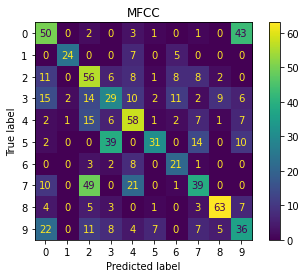

0.4662084765177549
0.4662084765177549


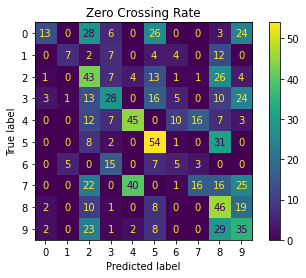

0.3344788087056128
0.3344788087056128
7844
888


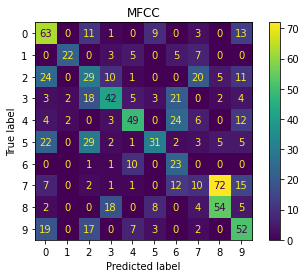

0.4222972972972973
0.4222972972972973


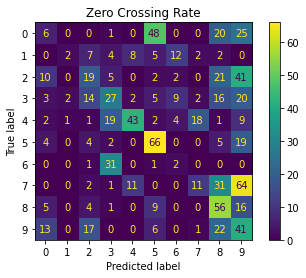

0.30743243243243246
0.30743243243243246
7807
925


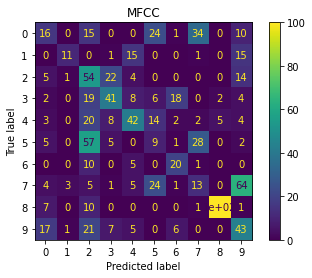

0.3772972972972973
0.3772972972972973


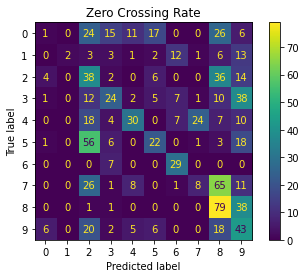

0.2983783783783784
0.2983783783783784
7742
990


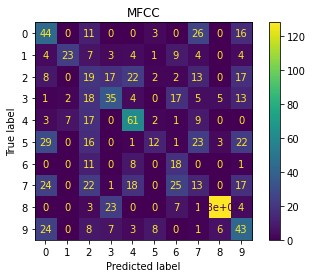

0.4
0.4


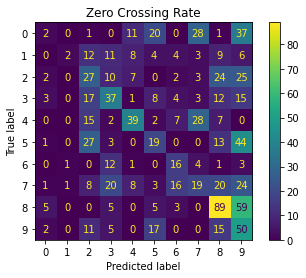

0.30303030303030304
0.30303030303030304
7796
936


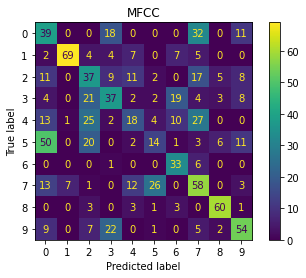

0.44764957264957267
0.44764957264957267


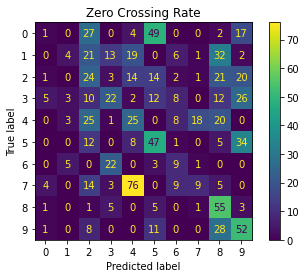

0.26495726495726496
0.26495726495726496
7909
823


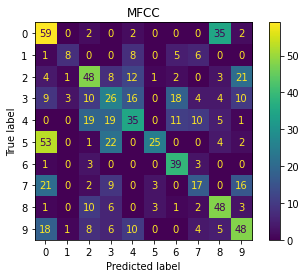

0.4289185905224787
0.4289185905224787


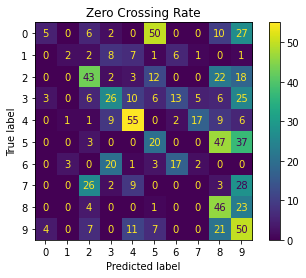

0.32077764277035237
0.32077764277035237
7894
838


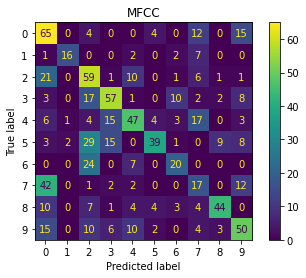

0.49403341288782815
0.49403341288782815


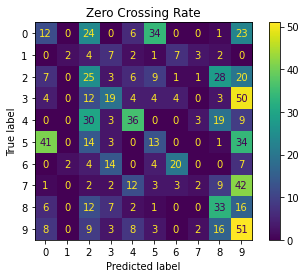

0.2541766109785203
0.2541766109785203
7926
806


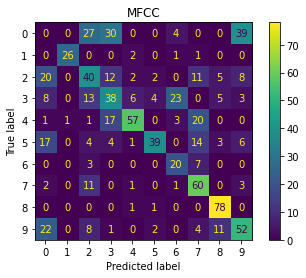

0.5086848635235732
0.5086848635235732


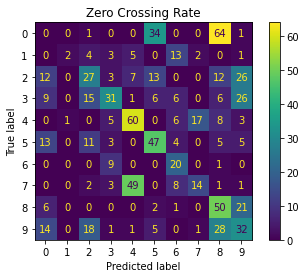

0.3511166253101737
0.3511166253101737
7916
816


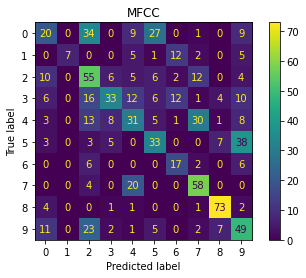

0.46078431372549017
0.46078431372549017


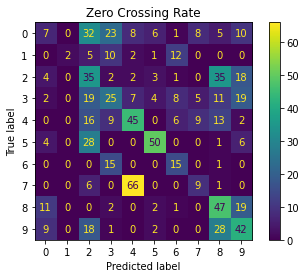

0.3394607843137255
0.3394607843137255
7895
837


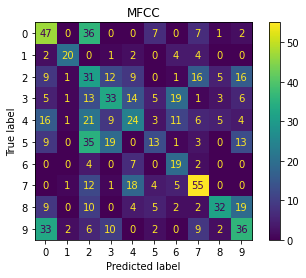

0.37037037037037035
0.37037037037037035


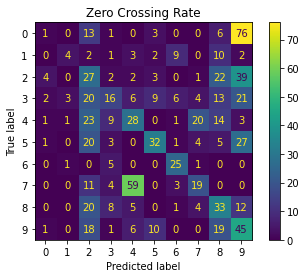

0.2747909199522103
0.2747909199522103


In [ ]:
SVM_accuracy_dictionary = {'MFCC': 0, 'Zero Crossing Rate': 0}
SVM_confusion_dictionary = {'MFCC': np.zeros((10, 10)), 'Zero Crossing Rate': np.zeros((10, 10))}

classifiers.append('SVM')

SVM_dictionary = {}

accuracy = 0
confusion = np.zeros((10, 10))



for i in range(1, 11):

  audios_train = []
  audios_test = []
  labels_train = []
  labels_test = []

  #splitting dataset in training and testing set
  for f in range(len(audios)):
    
    fold = int(folds[f])
    index = int(i)

    if (fold==index):
      audios_test.append(audios[f])
      labels_test.append(labels[f])

    else:
      audios_train.append(audios[f])
      labels_train.append(labels[f])



  for feature in features_names:
    

    #feature extraction
    feature_train = feature_computation(audios_train, feature)

    #scaling
    scaler = MinMaxScaler()
    scaler.fit(feature_train)
    scaler.transform(feature_train)

    classifier = svm.SVC()

    #fitting the classifier
    classifier.fit(feature_train, labels_train)

    SVM_dictionary[feature] = classifier

  #prediction of the testing set
  for feature in features_names:

    feature_test_value = feature_computation(audios_test, feature)

    plot = plot_confusion_matrix(SVM_dictionary[feature], feature_test_value, labels_test)
    plot.ax_.set_title(feature)
    plt.show()


    label_prediction = SVM_dictionary[feature].predict(feature_test_value)

    #computing the accuracy
    accuracy = compute_accuracy(label_prediction, labels_test) 
    SVM_accuracy_dictionary[feature] += accuracy

    #computing the confusion matrix
    confusion = compute_cm_multiclass(labels_test, label_prediction)
    SVM_confusion_dictionary[feature] += confusion


#computing mean value of the confusion matrix
for feature in features_names:
  SVM_confusion_dictionary[feature] = SVM_confusion_dictionary[feature] / 10.0





###RFC (Random Forest Classifier)

7859
873


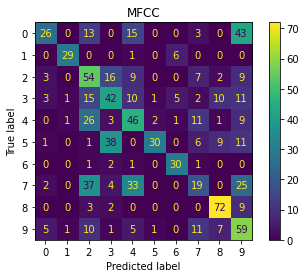

0.4662084765177549


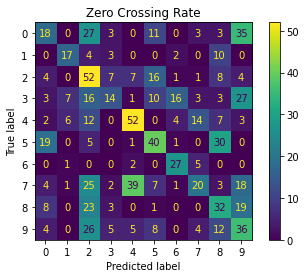

0.3528064146620848
7844
888


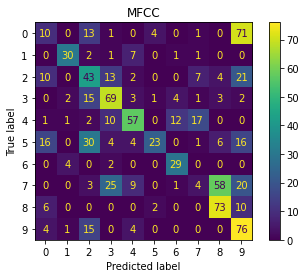

0.46621621621621623


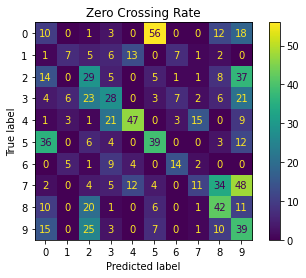

0.29954954954954954
7807
925


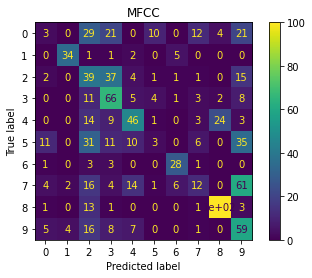

0.42162162162162165


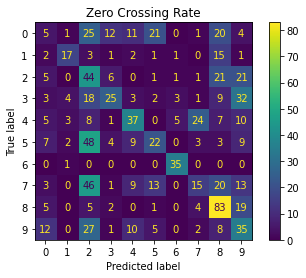

0.34378378378378377
7742
990


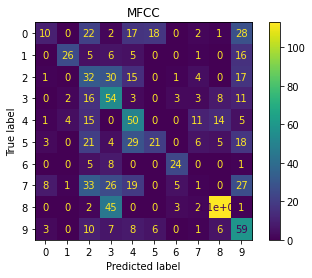

0.3939393939393939


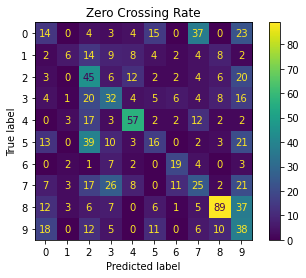

0.34444444444444444
7796
936


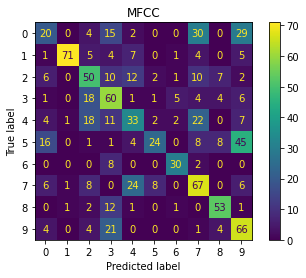

0.5064102564102564


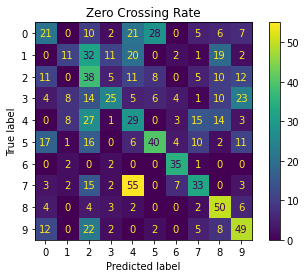

0.35363247863247865
7909
823


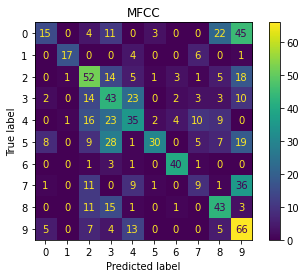

0.425273390036452


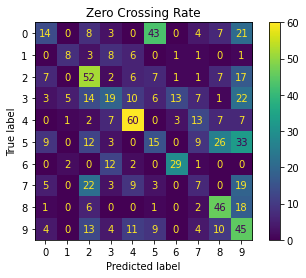

0.35844471445929527
7894
838


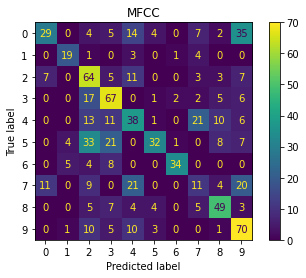

0.4928400954653938


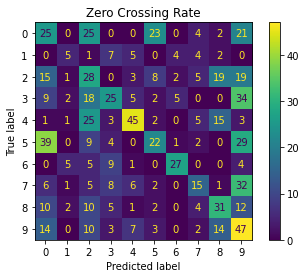

0.3221957040572792
7926
806


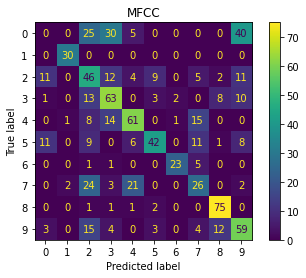

0.5272952853598015


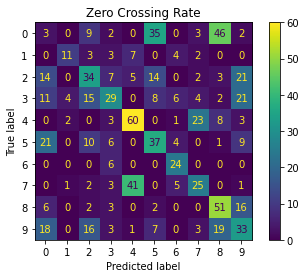

0.38089330024813894
7916
816


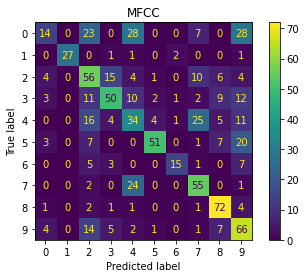

0.5392156862745098


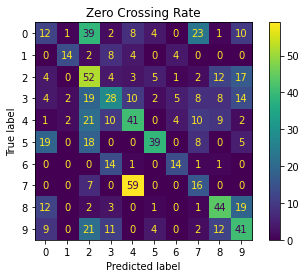

0.36887254901960786
7895
837


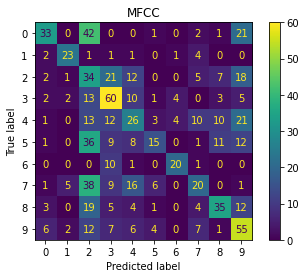

0.3835125448028674


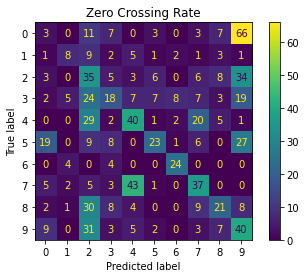

0.2974910394265233


In [ ]:
classifiers.append('RFC')


RFC_accuracy_dictionary = {'MFCC': 0, 'Zero Crossing Rate': 0}
RFC_confusion_dictionary = {'MFCC': np.zeros((10, 10)), 'Zero Crossing Rate': np.zeros((10, 10))}

RFC_dictionary = {}

accuracy = 0
confusion = np.zeros((10, 10))


for i in range(1, 11):

  audios_train = []
  audios_test = []
  labels_train = []
  labels_test = []

  #splitting dataset in training and testing set
  for f in range(len(audios)):
    
    fold = int(folds[f])
    index = int(i)

    if (fold==index):
      audios_test.append(audios[f])
      labels_test.append(labels[f])

    else:
      audios_train.append(audios[f])
      labels_train.append(labels[f])


  for feature in features_names:
    

    #feature extraction
    feature_train = feature_computation(audios_train, feature)

    #scaling
    scaler = MinMaxScaler()
    scaler.fit(feature_train)
    scaler.transform(feature_train)

    #fitting the classifier
    classifier = RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state=42)
    classifier.fit(feature_train, labels_train)
    RFC_dictionary[feature] = classifier 



  for feature in features_names:

    feature_test_value = feature_computation(audios_test, feature)

    plot = plot_confusion_matrix(RFC_dictionary[feature], feature_test_value, labels_test)
    plot.ax_.set_title(feature)
    plt.show()


    label_prediction = RFC_dictionary[feature].predict(feature_test_value)

    #computing the accuracy
    accuracy = compute_accuracy(label_prediction, labels_test)

    RFC_accuracy_dictionary[feature] += accuracy

    #computing the confusion matrix
    confusion = compute_cm_multiclass(labels_test, label_prediction)
    RFC_confusion_dictionary[feature] += confusion


#computing mean value of the confusion matrix
for feature in features_names:
  RFC_confusion_dictionary[feature] = RFC_confusion_dictionary[feature] / 10.0

#Performance Evaluation

In [ ]:
#printing the results for each classifier
print("Classifier : ", classifiers[0] , "\n")
  

for feature in features_names:
  
     print("Feature computed : ", feature, "\n \n")
     print("Accuracy : ", SVM_accuracy_dictionary[feature]/10, "\n")
     print("Confusion Matrix : \n \n", SVM_confusion_dictionary[feature], "\n")
     print("\n")

print("-------------------------------------------------------- \n");

print("\n\n")

print("Classifier : ", classifiers[1], "\n")

for feature in features_names:
  
     print("Feature computed : ", feature, "\n \n")
     #printing the mean value of accuracy
     print("Accuracy : ", RFC_accuracy_dictionary[feature]/10, "\n")
     #printing the mean value of teh confusion matrix
     print("Confusion Matrix : \n \n", RFC_confusion_dictionary[feature], "\n")
 




['SVM', 'SVM', 'SVM', 'SVM', 'RFC']
Classifier :  SVM 

Feature computed :  MFCC 
 

Accuracy :  0.43762441947916625 

Confusion Matrix : 
 
 [[40.3  0.  14.2  4.9  1.4  7.5  0.5 11.6  3.6 16. ]
 [ 1.  22.6  1.1  1.2  5.7  0.2  5.   3.7  0.   2.4]
 [12.3  0.3 42.8 10.3  8.4  1.4  1.6 10.3  2.6 10. ]
 [ 5.6  1.  15.9 37.1  7.8  2.8 16.8  1.9  3.9  7.2]
 [ 5.1  1.4 13.5  8.7 42.2  3.3  6.8 13.4  1.7  3.9]
 [19.3  0.2 19.4 11.1  0.5 24.6  0.7  8.8  3.7 11.7]
 [ 0.1  0.   6.5  0.4  4.5  0.  23.   2.2  0.   0.7]
 [12.3  1.1 10.9  1.5  9.8  5.7  4.5 34.   7.2 13. ]
 [ 3.7  0.   4.8  5.2  1.3  2.3  1.6  1.8 68.   4.2]
 [19.   0.4 11.9  6.9  4.   3.   0.6  3.8  4.1 46.3]] 



Feature computed :  Zero Crossing Rate 
 

Accuracy :  0.30485997708289736 

Confusion Matrix : 
 
 [[ 4.8  0.  15.6  4.8  4.  28.7  0.1  3.6 13.8 24.6]
 [ 0.   2.9  6.2  6.7  5.5  2.   8.5  1.3  7.3  2.5]
 [ 4.5  0.  30.8  3.9  4.5  7.5  0.9  0.7 24.7 22.5]
 [ 3.5  0.9 13.8 25.5  3.5  7.5  7.   2.   9.9 26.4]
 [ 0.3  0.7